<a href="https://colab.research.google.com/github/JamionW/Advanced-Analysis-of-Algorithms/blob/master/Combinatorial_Inverse_Elasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the Master Code Notebook for Inverse Elasticity

# Necessary libraries

In [1]:
!pip install rtree
!pip install fiona

In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import pyproj
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points, transform
import fiona
from scipy.spatial import cKDTree
from joblib import Parallel, delayed
from functools import lru_cache
from typing import Dict, List, Tuple
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import rtree
import random
import math
from collections import defaultdict, Counter

#Global variable for FIPS Code

In [3]:
FIPS_TARGET = '47065000800'
#FIPS_TARGET = '47065000600'  # Replace with desired FIPS code

# Dataset Imports and Set Coordinate Systems

In [4]:
def import_data(address_file, svi_file, roads_file):
    print("Importing data...")

    # Import addresses
    print("Importing addresses...")
    address_df = gpd.read_file(address_file)
    print(f"Imported {len(address_df)} addresses.")

    # Import SVI data
    print("Importing SVI data...")
    svi_df = gpd.read_file(svi_file, layer='SVI2022_TENNESSEE_tract')
    print(f"Imported SVI data for {len(svi_df)} tracts.")

    # Import roads
    print("Importing roads...")
    with fiona.open(roads_file) as collection:
        roads_df = gpd.GeoDataFrame.from_features(collection)
    roads_df.set_crs(epsg=4326, inplace=True)  # Set initial CRS to WGS84
    print(f"Imported {len(roads_df)} road segments.")

    # Create samples dictionary
    samples_dict = {
        'address': address_df.head().to_dict('records'),
        'svi': svi_df.head().to_dict('records'),
        'roads': roads_df.head().to_dict('records')
    }

    return address_df, svi_df, roads_df, samples_dict

In [5]:
def set_crs(address_df, svi_df, roads_df, target_crs="EPSG:32618"):
    print(f"Setting CRS to {target_crs} for all datasets...")

    # Check and reproject roads_df if necessary
    if roads_df.crs is None:
        print("Roads CRS is None. Setting to EPSG:4326 (WGS84).")
        roads_df.set_crs(epsg=4326, inplace=True)

    if roads_df.crs.to_string() != target_crs:
        print(f"Reprojecting roads from {roads_df.crs} to {target_crs}")
        roads_df = roads_df.to_crs(target_crs)

    # Check and reproject address_df if necessary
    if address_df.crs is None or address_df.crs.to_string() != target_crs:
        print(f"Reprojecting addresses from {address_df.crs} to {target_crs}")
        address_df = address_df.to_crs(target_crs)

    # Check and reproject svi_df if necessary
    if svi_df.crs is None or svi_df.crs.to_string() != target_crs:
        print(f"Reprojecting SVI data from {svi_df.crs} to {target_crs}")
        svi_df = svi_df.to_crs(target_crs)

    print(f"Roads CRS: {roads_df.crs}")
    print(f"Addresses CRS: {address_df.crs}")
    print(f"SVI CRS: {svi_df.crs}")

    return address_df, svi_df, roads_df

In [6]:
# Define file paths
address_file = '/content/drive/MyDrive/Colab Notebooks/data/chattanooga.geojson'
svi_file = "/content/drive/MyDrive/Colab Notebooks/data/SVI2022_TENNESSEE_tract.gdb"
roads_file = '/content/drive/MyDrive/Colab Notebooks/data/tl_2023_47065_roads.shp'

# Import data
address_df, svi_df, roads_df, samples_dict = import_data(address_file, svi_file, roads_file)

# Set CRS
address_df, svi_df, roads_df = set_crs(address_df, svi_df, roads_df)

Importing data...
Importing addresses...
Imported 102761 addresses.
Importing SVI data...
Imported SVI data for 1701 tracts.
Importing roads...
Imported 13778 road segments.
Setting CRS to EPSG:32618 for all datasets...
Reprojecting roads from EPSG:4326 to EPSG:32618
Reprojecting addresses from EPSG:4326 to EPSG:32618
Reprojecting SVI data from EPSG:4269 to EPSG:32618
Roads CRS: EPSG:32618
Addresses CRS: EPSG:32618
SVI CRS: EPSG:32618


In [7]:
# Perform a spatial join between address_df and svi_df
# Use 'predicate' instead of 'op' for the spatial join operation
address_svi_joined = gpd.sjoin(address_df, svi_df, how="left", predicate='intersects')

# Group the joined dataframe by FIPS code and count the number of addresses in each group
address_by_fips = address_svi_joined.groupby('FIPS').size()

# Print the distribution of addresses by FIPS code
print(address_by_fips)

FIPS
47065000400    1594
47065000600    2096
47065000700    1777
47065000800    1351
47065001100     923
               ... 
47065012300    2564
47065012400    2316
47065980100      25
47065980200      81
47115050201       8
Length: 72, dtype: int64


# Address Filtering for Computational Efficiency

In [8]:
def filter_data_for_target_area(target_area: str,
                                address_df: gpd.GeoDataFrame,
                                svi_df: gpd.GeoDataFrame,
                                roads_df: gpd.GeoDataFrame) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Filter the input data to include only the target tract and its immediate neighbors.

    Parameters:
    -----------
    target_area : str
        The FIPS code of the target census tract.
    address_df : gpd.GeoDataFrame
        GeoDataFrame containing all addresses.
    svi_df : gpd.GeoDataFrame
        GeoDataFrame containing SVI data for all tracts.
    roads_df : gpd.GeoDataFrame
        GeoDataFrame containing all road segments.

    Returns:
    --------
    Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]
        Filtered address_df, svi_df, and roads_df.
    """
    # Get the target tract
    target_tract = svi_df[svi_df['FIPS'] == target_area]
    if target_tract.empty:
        raise ValueError(f"Target area {target_area} not found in svi_df")

    # Find neighboring tracts
    neighboring_tracts = svi_df[svi_df.geometry.touches(target_tract.geometry.iloc[0])]

    # Combine target and neighboring tracts
    tracts_of_interest = pd.concat([target_tract, neighboring_tracts])

    # Create a unified geometry of all tracts of interest
    unified_geometry = tracts_of_interest.geometry.unary_union

    # Filter address_df
    filtered_address_df = address_df[address_df.geometry.within(unified_geometry)]

    # Filter roads_df
    filtered_roads_df = roads_df[roads_df.intersects(unified_geometry)]

    # Filter svi_df
    filtered_svi_df = tracts_of_interest

    print(f"Filtered {len(filtered_address_df)} addresses, {len(filtered_roads_df)} road segments, and {len(filtered_svi_df)} census tracts.")

    return filtered_address_df, filtered_svi_df, filtered_roads_df

# Usage
target_area = FIPS_TARGET
address_df, svi_df, roads_df = filter_data_for_target_area(target_area, address_df, svi_df, roads_df)


<ipython-input-8-8168cfef8d37>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unified_geometry = tracts_of_interest.geometry.unary_union


Filtered 10098 addresses, 857 road segments, and 7 census tracts.


# Graph Creation

In [9]:
def create_graph_from_roads_and_addresses(roads_gdf: gpd.GeoDataFrame, address_gdf: gpd.GeoDataFrame, target_crs='EPSG:32618') -> nx.Graph:
    print(f"Creating graph in CRS: {target_crs}")

    # Ensure both GeoDataFrames are in the target CRS
    if roads_gdf.crs != target_crs:
        roads_gdf = roads_gdf.to_crs(target_crs)
    if address_gdf.crs != target_crs:
        address_gdf = address_gdf.to_crs(target_crs)

    G = nx.Graph()

    # Add roads to the graph
    for idx, row in roads_gdf.iterrows():
        if row.geometry.geom_type == 'LineString':
            coords = list(row.geometry.coords)
            for start, end in zip(coords[:-1], coords[1:]):
                G.add_edge(start, end, geometry=LineString([start, end]), length=Point(start).distance(Point(end)))
        else:
            print(f"Skipping non-LineString geometry at index {idx}")

    print(f"Added {G.number_of_edges()} road segments to the graph")

    # Create a spatial index for efficient nearest edge lookup
    edges = list(G.edges(data=True))
    edge_geoms = [data['geometry'] for _, _, data in edges]
    spatial_index = rtree.index.Index()
    for idx, geom in enumerate(edge_geoms):
        spatial_index.insert(idx, geom.bounds)

    print(f"Created spatial index with {len(edge_geoms)} edges")

    # Dictionary to store addresses projecting to the same point
    projected_points = defaultdict(list)
    skipped_points = []

    MAX_GROUP_DISTANCE = 10  # meters

    # First pass: project all addresses and group them
    for idx, row in address_gdf.iterrows():
        point = row.geometry
        point_id = row['hash']  # Use 'hash' as point_id

        # Find the nearest edge using the spatial index
        nearest_indices = list(spatial_index.nearest(point.bounds, 1))
        if not nearest_indices:
            print(f"No nearest edge found for address {idx}")
            skipped_points.append(point_id)
            continue
        nearest_idx = nearest_indices[0]
        nearest_edge = edges[nearest_idx]
        edge_geom = nearest_edge[2]['geometry']

        # Project the point onto the nearest edge
        nearest_point = edge_geom.interpolate(edge_geom.project(point))

        # Move the projected point slightly towards the original point
        vector = Point(point.x - nearest_point.x, point.y - nearest_point.y)
        magnitude = math.sqrt(vector.x ** 2 + vector.y ** 2)
        if magnitude > 0:
            unit_vector = Point(vector.x / magnitude, vector.y / magnitude)
            offset_distance = min(magnitude, 5)  # max 5 meters offset
            projected_point = Point(nearest_point.x + unit_vector.x * offset_distance,
                                    nearest_point.y + unit_vector.y * offset_distance)
        else:
            projected_point = nearest_point

        node_coords = (round(projected_point.x, 6), round(projected_point.y, 6))

        # Store the address information for this projected point
        projected_points[node_coords].append({
            'original_point': point,
            'address_id': idx,
            'point_id': point_id
        })

    print(f"Total unique projected points: {len(projected_points)}")
    print(f"Total skipped points: {len(skipped_points)}")

    def group_addresses(addresses):
        grouped = []
        for addr in addresses:
            if not grouped or all(addr['original_point'].distance(g['original_point']) > MAX_GROUP_DISTANCE for g in grouped):
                grouped.append(addr)
        return grouped

    # Analyze grouped addresses
    grouped_address_counts = [len(addresses) for addresses in projected_points.values() if len(addresses) > 1]
    print(f"Number of points with multiple addresses: {len(grouped_address_counts)}")
    print(f"Distribution of grouped address counts: {Counter(grouped_address_counts)}")

    non_zero_distance_groups = 0
    for node_coords, addresses in projected_points.items():
        if len(addresses) > 1:
            distances = [addresses[0]['original_point'].distance(addr['original_point']) for addr in addresses[1:]]
            max_distance = max(distances)
            if max_distance > 0.00:
                non_zero_distance_groups += 1
                print(f"Grouped addresses at {node_coords}:")
                print(f"  Number of addresses: {len(addresses)}")
                print(f"  Max distance between addresses: {max_distance:.2f} meters")
                print(f"  Original coordinates:")
                for addr in addresses:
                    print(f"    {addr['original_point'].coords[0]}")

    print(f"Number of address groups with non-zero distances: {non_zero_distance_groups}")

    # Second pass: add nodes and connect them to the graph
    point_id_to_coords = {}  # New dictionary to store point_id to coordinates mapping
    address_nodes_added = 0
    for node_coords, addresses in projected_points.items():
        grouped_addresses = group_addresses(addresses)
        G.add_node(node_coords,
                   type='address',
                   addresses=grouped_addresses,
                   projected_coord=node_coords,
                   original_coords=[addr['original_point'].coords[0] for addr in grouped_addresses])

        for addr in grouped_addresses:
            point_id_to_coords[addr['point_id']] = node_coords

        address_nodes_added += 1

        # Find the nearest edge again (we need to do this to get the edge endpoints)
        nearest_indices = list(spatial_index.nearest(Point(node_coords).bounds, 1))
        if not nearest_indices:
            print(f"No nearest edge found for node {node_coords}")
            continue
        nearest_idx = nearest_indices[0]
        nearest_edge = edges[nearest_idx]

        # Connect the address node to the endpoints of the nearest edge
        G.add_edge(node_coords, nearest_edge[0], length=Point(node_coords).distance(Point(nearest_edge[0])))
        G.add_edge(node_coords, nearest_edge[1], length=Point(node_coords).distance(Point(nearest_edge[1])))

    # Add the point_id_to_coords mapping to the graph object
    G.graph['point_id_to_coords'] = point_id_to_coords
    G.graph['crs'] = target_crs

    total_addresses_processed = sum(len(addresses) for addresses in projected_points.values())
    print(f"Total addresses processed: {total_addresses_processed}")
    print(f"Unique projected points: {len(projected_points)}")
    print(f"Addresses per projected point: {total_addresses_processed / len(projected_points):.2f}")
    print(f"Total address nodes added to the graph: {address_nodes_added}")
    print(f"Final graph: {len(G.nodes())} nodes, {len(G.edges())} edges")
    print(f"Number of point_ids in mapping: {len(point_id_to_coords)}")
    print(f"Number of skipped points: {len(skipped_points)}")

    return G

In [10]:
def verify_graph(G):
    address_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'address']
    print(f"Total nodes in graph: {G.number_of_nodes()}")
    print(f"Address nodes in graph: {len(address_nodes)}")
    print(f"Sample of address nodes: {address_nodes[:5]}")
    #print(f"Sample of node data: {[G.nodes[node] for node in address_nodes[:5]]}")

In [11]:
# Create the graph in the target CRS
G = create_graph_from_roads_and_addresses(roads_df, address_df, target_crs='EPSG:32618')

# Validation step
verify_graph(G)

Creating graph in CRS: EPSG:32618
Added 15528 road segments to the graph
Created spatial index with 15528 edges
Total unique projected points: 7783
Total skipped points: 0
Number of points with multiple addresses: 748
Distribution of grouped address counts: Counter({3: 245, 4: 210, 2: 158, 6: 50, 5: 21, 11: 15, 9: 14, 13: 11, 10: 10, 7: 4, 20: 3, 24: 3, 16: 1, 22: 1, 27: 1, 8: 1})
Number of address groups with non-zero distances: 0
Total addresses processed: 10098
Unique projected points: 7783
Addresses per projected point: 1.30
Total address nodes added to the graph: 7783
Final graph: 22698 nodes, 31094 edges
Number of point_ids in mapping: 7783
Number of skipped points: 0
Total nodes in graph: 22698
Address nodes in graph: 7783
Sample of address nodes: [(-441744.871308, 3927098.617492), (-439870.086045, 3933100.39619), (-440059.946301, 3930208.780425), (-439674.185137, 3933694.488264), (-440288.616115, 3931619.965651)]


In [12]:
print("Graph attributes after projection:")
print(G.graph.keys())
print("point_id_to_coords in projected graph:")
print(len(G.graph.get('point_id_to_coords', {})))
print("Sample of point_id_to_coords after projection:")
print(list(G.graph['point_id_to_coords'].items())[:5])
print("Number of nodes in projected graph:", G.number_of_nodes())
print("Number of edges in projected graph:", G.number_of_edges())

Graph attributes after projection:
dict_keys(['point_id_to_coords', 'crs'])
point_id_to_coords in projected graph:
7783
Sample of point_id_to_coords after projection:
[('1471fbf8de5873ae', (-441744.871308, 3927098.617492)), ('75a3f0f898414814', (-439870.086045, 3933100.39619)), ('54c943924c5d4006', (-440059.946301, 3930208.780425)), ('6ebe3a5b7a6045f4', (-439674.185137, 3933694.488264)), ('02bc23ea3188a4b2', (-440288.616115, 3931619.965651))]
Number of nodes in projected graph: 22698
Number of edges in projected graph: 31094


In [13]:
def check_graph_connectivity(G):
    connected_components = list(nx.connected_components(G))
    print(f"Number of connected components: {len(connected_components)}")
    if len(connected_components) > 1:
        print("Graph is not fully connected!")
        print(f"Sizes of components: {[len(c) for c in connected_components]}")

    isolated_nodes = list(nx.isolates(G))
    print(f"Number of isolated nodes: {len(isolated_nodes)}")
    if isolated_nodes:
        print(f"Sample of isolated nodes: {isolated_nodes[:10]}")

# Call this function after creating the graph
check_graph_connectivity(G)

Number of connected components: 1
Number of isolated nodes: 0


# Euclidean Elasticity with Decay

In [14]:
def calculate_euclidean_inverse_elasticity(
    target_area_data: gpd.GeoDataFrame,
    point_gdf: gpd.GeoDataFrame,
    area_index_gdf: gpd.GeoDataFrame,
    lambda_param: float = 0.001,
    beta: float = 1,
    index_column: str = 'RPL_THEMES',
    area_id_column: str = 'FIPS'
) -> pd.DataFrame:
    print("Starting calculate_euclidean_inverse_elasticity")
    print(f"Points in point_gdf: {len(point_gdf)}")

    target_geometry = target_area_data.geometry
    print(f"Target area size: {target_geometry.area}")

    points_within = point_gdf[point_gdf.geometry.within(target_geometry)]
    print(f"Points within target area: {len(points_within)}")

    neighboring_areas = area_index_gdf[area_index_gdf.geometry.touches(target_geometry)]
    print(f"Number of neighboring areas: {len(neighboring_areas)}")

    results = []
    for _, point in points_within.iterrows():
        point_geom = point.geometry
        point_id = point['hash']  # Use 'hash' as the point identifier

        for _, neighbor_area in neighboring_areas.iterrows():
            nearest_point = nearest_points(point_geom, neighbor_area.geometry)[1]
            distance = point_geom.distance(nearest_point)

            target_index = target_area_data[index_column]
            neighbor_index = neighbor_area[index_column]
            index_difference = abs(target_index - neighbor_index)

            if index_difference == 0:
                inverse_elasticity = float('inf')
            else:
                inverse_elasticity = np.exp(-lambda_param * distance) / (index_difference ** beta)

            results.append({
                'target_area': target_area_data[area_id_column],
                'point_id': point_id,
                'neighbor_area': neighbor_area[area_id_column],
                'distance_euclidean': distance,
                'inverse_elasticity_euclidean': inverse_elasticity
            })

    print(f"Total results calculated: {len(results)}")
    return pd.DataFrame(results)

# Network Elasticity with Decay

In [15]:
def calculate_network_inverse_elasticity(
    G: nx.Graph,
    target_area_data: pd.Series,
    point_gdf: gpd.GeoDataFrame,
    area_index_gdf: gpd.GeoDataFrame,
    euclidean_results: pd.DataFrame,
    lambda_param: float = 0.001,
    beta: float = 1,
    index_column: str = 'RPL_THEMES',
    area_id_column: str = 'FIPS'
) -> pd.DataFrame:
    target_geometry = target_area_data.geometry
    points_within = point_gdf[point_gdf.geometry.within(target_geometry)]
    neighboring_areas = area_index_gdf[area_index_gdf.geometry.touches(target_geometry)]

    point_to_node = G.graph.get('point_id_to_coords', {})

    # Precompute nearest nodes for neighboring areas
    neighbor_nodes = {}
    for _, neighbor_area in neighboring_areas.iterrows():
        nearest_point = nearest_points(target_geometry.centroid, neighbor_area.geometry)[1]
        neighbor_nodes[neighbor_area[area_id_column]] = min(G.nodes(), key=lambda n: Point(n).distance(nearest_point))

    # Create a dictionary for fast lookup of euclidean distances
    euclidean_distances = euclidean_results.set_index(['point_id', 'neighbor_area'])['distance_euclidean'].to_dict()

    results = []
    failed_points = []
    for _, row in points_within.iterrows():
        point_id = row['hash']
        point_node = point_to_node.get(point_id)
        if point_node is None:
            #print(f"Point node not found for point_id: {point_id}")
            failed_points.append(('missing_node', point_id))
            continue

        for _, neighbor_area in neighboring_areas.iterrows():
            neighbor_id = neighbor_area[area_id_column]
            neighbor_node = neighbor_nodes[neighbor_id]
            euclidean_distance = euclidean_distances.get((point_id, neighbor_id), 0)

            try:
                network_distance = nx.astar_path_length(G, point_node, neighbor_node,
                                                        heuristic=lambda u, v: euclidean_distance,
                                                        weight='length')
                used_euclidean_fallback = False
            except nx.NetworkXNoPath:
                print(f"No path found between {point_id} and {neighbor_id}")
                failed_points.append(('no_path', point_id, neighbor_id))
                network_distance = euclidean_distance
                used_euclidean_fallback = True

            index_difference = abs(target_area_data[index_column] - neighbor_area[index_column])

            if index_difference == 0:
                inverse_elasticity = float('inf')
            else:
                inverse_elasticity = np.exp(-lambda_param * network_distance) / (index_difference ** beta)

            results.append({
                'target_area': target_area_data[area_id_column],
                'point_id': point_id,
                'neighbor_area': neighbor_id,
                'network_distance': network_distance,
                'inverse_elasticity_network': inverse_elasticity,
                'used_euclidean_fallback': used_euclidean_fallback
            })

    print(f"Total failed points: {len(failed_points)}")
    print(f"Failed points sample: {failed_points[:10]}")

    return pd.DataFrame(results)

#Combine Elasticities

In [16]:
def combine_elasticities_and_calculate_weighted_index(network_df, euclidean_df, area_index_gdf, network_weight=0.7, index_column='RPL_THEMES', area_id_column='FIPS'):
    print(f"Starting combine_elasticities_and_calculate_weighted_index")
    print(f"Network df shape: {network_df.shape}, Euclidean df shape: {euclidean_df.shape}")

    if network_df.empty:
        print("Warning: Network DataFrame is empty. Proceeding with Euclidean results only.")
        combined_df = euclidean_df.copy()
        combined_df['combined_inverse_elasticity'] = combined_df['inverse_elasticity_euclidean']
        combined_df['combined_distance'] = combined_df['distance_euclidean']
    else:
        # Merge the two DataFrames
        #print(f"DEBUG DEBUG DEBUG")
        #print(f"Euclidean_df head:")
        #print(euclidean_df.head())
        #print(f"Network_df head:")
        #print(network_df.head())
        print(f"Distribution of eucidean fallbacks:")
        print(network_df['used_euclidean_fallback'].value_counts())
        #print(f"DEBUG DEBUG DEBUG")

        combined_df = pd.merge(euclidean_df, network_df,
                               on=['target_area', 'neighbor_area', 'point_id'],
                               how='left')
        print(f"Combined df shape after merge: {combined_df.shape}")

        # Check for any rows where network data is missing
        network_nulls = combined_df[combined_df['network_distance'].isnull()]
        print(f"Rows missing network data: {len(network_nulls)}")

        # Calculate combined inverse elasticity and distance
        euclidean_weight = 1 - network_weight
        combined_df['combined_inverse_elasticity'] = np.where(
            combined_df['inverse_elasticity_network'].isnull(),
            combined_df['inverse_elasticity_euclidean'],
            network_weight * combined_df['inverse_elasticity_network'] + euclidean_weight * combined_df['inverse_elasticity_euclidean']
        )
        combined_df['combined_distance'] = np.where(
            combined_df['network_distance'].isnull(),
            combined_df['distance_euclidean'],
            network_weight * combined_df['network_distance'] + euclidean_weight * combined_df['distance_euclidean']
        )

    # Prepare for weighted index calculation
    target_indices = area_index_gdf.set_index(area_id_column)[index_column]
    combined_df['target_index'] = combined_df['target_area'].map(target_indices)
    combined_df['neighbor_index'] = combined_df['neighbor_area'].map(target_indices)

    # Calculate weights
    grouped = combined_df.groupby('point_id')
    total_weights = grouped['combined_inverse_elasticity'].transform('sum')
    combined_df['weight'] = combined_df['combined_inverse_elasticity'] / total_weights

    # Calculate weighted index difference for each point-neighbor combination
    combined_df['weighted_diff'] = (combined_df['neighbor_index'] - combined_df['target_index']) * combined_df['weight']

    # Aggregate the results
    weighted_index_df = grouped.agg({
        'target_area': 'first',
        'target_index': 'first',
        'weighted_diff': 'sum',
    }).reset_index()

    weighted_index_df['neighbor_count'] = grouped.size().values
    weighted_index_df['weighted_index'] = weighted_index_df['target_index'] + weighted_index_df['weighted_diff']

    print(f"Final weighted index df shape: {weighted_index_df.shape}")
    print(f"Number of unique point_ids: {weighted_index_df['point_id'].nunique()}")
    print(f"Distribution of number of neighboring areas per point:")
    print(weighted_index_df['neighbor_count'].describe())

    return weighted_index_df[['target_area', 'point_id', 'weighted_index']]

#Processing by Tract

In [17]:
def process_target_area(target_area, area_index_gdf, point_gdf, G, lambda_param=0.001, beta=1, network_weight=0.7, index_column='RPL_THEMES', area_id_column='FIPS'):
    print(f"Starting combined process for target area: {target_area}")

    target_area_data = area_index_gdf[area_index_gdf[area_id_column] == target_area].iloc[0]

    print("Graph attributes after creation:")
    print(G.graph.keys())
    print("point_id_to_coords in graph (after creation):")
    print(len(G.graph.get('point_id_to_coords', {})))
    print(list(G.graph.get('point_id_to_coords', {}).items())[:5])

    # Calculate Euclidean-based inverse elasticity first
    euclidean_result = calculate_euclidean_inverse_elasticity(target_area_data, point_gdf, area_index_gdf, lambda_param, beta, index_column, area_id_column)

    print("Graph attributes just before calculate_network_inverse_elasticity:")
    print(G.graph.keys())
    print("point_id_to_coords in graph (just before calculate_network_inverse_elasticity):")
    print(len(G.graph.get('point_id_to_coords', {})))

    # Calculate network-based inverse elasticity using Euclidean results as heuristics
    network_result = calculate_network_inverse_elasticity(G, target_area_data, point_gdf, area_index_gdf, euclidean_result, lambda_param, beta, index_column, area_id_column)

    # Ensure both results have a 'target_area' column
    if 'target_area' not in network_result.columns:
        network_result['target_area'] = target_area
    if 'target_area' not in euclidean_result.columns:
        euclidean_result['target_area'] = target_area

    # Combine the results and calculate weighted index
    combined_result = combine_elasticities_and_calculate_weighted_index(
        network_result, euclidean_result, area_index_gdf, network_weight, index_column, area_id_column
    )

    print(f"Rows in combined result: {len(combined_result)}")

    return combined_result


In [18]:
def verify_point_id_mapping(G, point_gdf):
    point_ids_in_gdf = set(point_gdf['hash'])
    point_ids_in_graph = set(G.graph['point_id_to_coords'].keys())

    missing_ids = point_ids_in_gdf - point_ids_in_graph
    extra_ids = point_ids_in_graph - point_ids_in_gdf

    print(f"Number of point_ids in GeoDataFrame: {len(point_ids_in_gdf)}")
    print(f"Number of point_ids in Graph mapping: {len(point_ids_in_graph)}")
    print(f"Number of missing point_ids: {len(missing_ids)}")
    print(f"Number of extra point_ids: {len(extra_ids)}")

    if missing_ids:
        print(f"Sample of missing point_ids: {list(missing_ids)[:10]}")

# Call this function before calculate_network_inverse_elasticity
verify_point_id_mapping(G, address_df)

Number of point_ids in GeoDataFrame: 10098
Number of point_ids in Graph mapping: 7783
Number of missing point_ids: 2315
Number of extra point_ids: 0
Sample of missing point_ids: ['a205d1ec3d298d61', 'da03d859148824f1', '4d8c14a88ee76ecf', '65321973074cb7ee', '507f5e42902e855d', 'dbceb6a9c1e5e190', 'ead757ebe5be24b1', 'df5461b14e8c7df0', '7e5a33092b5f5eaf', '533501c3ce1911b9']


# Execution Step

*   Increase lambda_param to make the influence decay more quickly
with distance.
*   Decrease lambda_param to allow influence to extend further.
*   Increase beta to make the function more sensitive to SVI differences.
*   Decrease beta to make the function less sensitive to SVI differences.


---

As the network_weight increases (approaches 1):

More weight is given to the network-based distance and inverse elasticity calculations.

Less weight is given to the Euclidean-based calculations.

So:

When network_weight = 1: The result is based entirely on network distance (road network).

When network_weight = 0: The result is based entirely on Euclidean distance (straight-line).

When network_weight = 0.7 (as in the example): The result is 70% influenced by network distance and 30% by Euclidean distance.

---

target_area: The specific area you're analyzing

svi_df: Your DataFrame containing SVI (Social Vulnerability Index) data

address_df: Your DataFrame containing address point data

G_projected: Your projected NetworkX graph object

lambda_param: The decay parameter

beta: The exponent for index difference sensitivity

network_weight: The weight given to network-based calculations vs. Euclidean-based calculations

index_column: The name of the column containing the index values (SVI in this case)

area_id_column: The name of the column containing area identifiers

In [19]:
# Usage
target_area = FIPS_TARGET
lambda_param = 0.0015
beta = 0.96
network_weight = 0.7

combined_result_df = process_target_area(
    target_area,
    svi_df,
    address_df,
    G,
    lambda_param,
    beta,
    network_weight,
    index_column='RPL_THEMES',
    area_id_column='FIPS'
)

Starting combined process for target area: 47065000800
Graph attributes after creation:
dict_keys(['point_id_to_coords', 'crs'])
point_id_to_coords in graph (after creation):
7783
[('1471fbf8de5873ae', (-441744.871308, 3927098.617492)), ('75a3f0f898414814', (-439870.086045, 3933100.39619)), ('54c943924c5d4006', (-440059.946301, 3930208.780425)), ('6ebe3a5b7a6045f4', (-439674.185137, 3933694.488264)), ('02bc23ea3188a4b2', (-440288.616115, 3931619.965651))]
Starting calculate_euclidean_inverse_elasticity
Points in point_gdf: 10098
Target area size: 1906533.8358163603
Points within target area: 1351
Number of neighboring areas: 6
Total results calculated: 8106
Graph attributes just before calculate_network_inverse_elasticity:
dict_keys(['point_id_to_coords', 'crs'])
point_id_to_coords in graph (just before calculate_network_inverse_elasticity):
7783
Total failed points: 350
Failed points sample: [('missing_node', 'f4139a8a99f0d890'), ('missing_node', '7e14ce36e593bff7'), ('missing_node', 

# Index combination with elasticity set

In [20]:
def combine_and_compare_svi(combined_result_df, address_df, svi_df):
    """
    Combines the calculated weighted index with the original address data and compares it to the tract-level SVI.

    Parameters:
    combined_result_df (pd.DataFrame): Result from process_target_area function
    address_df (pd.DataFrame): Original address DataFrame
    svi_df (pd.DataFrame): Original SVI DataFrame

    Returns:
    pd.DataFrame: DataFrame with address-level and tract-level SVI, and their difference
    """
    # Rename 'hash' to 'point_id' in address_df for clarity
    address_df = address_df.rename(columns={'hash': 'point_id'})

    # Perform the join
    address_df_with_svi = address_df.merge(combined_result_df, on='point_id', how='left')

    # Ensure the result is a GeoDataFrame
    address_df_with_svi = gpd.GeoDataFrame(address_df_with_svi, geometry='geometry', crs=address_df.crs)

    # Join the census tract SVI to the address_df_with_svi
    address_df_with_both_svi = address_df_with_svi.merge(
        svi_df[['FIPS', 'RPL_THEMES']],
        left_on='target_area',
        right_on='FIPS',
        how='left'
    )

    # Rename the columns for clarity
    address_df_with_both_svi = address_df_with_both_svi.rename(columns={
        'weighted_index': 'address_level_svi',
        'RPL_THEMES': 'tract_level_svi'
    })

    # Calculate the difference between the two SVI measures
    address_df_with_both_svi['svi_difference'] = address_df_with_both_svi['address_level_svi'] - address_df_with_both_svi['tract_level_svi']

    return address_df_with_both_svi

# Final Sanitization and Dataset Creation

In [21]:
def sanitize_svi_data(df: gpd.GeoDataFrame, address_df: gpd.GeoDataFrame, svi_df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Sanitize the SVI data by removing unnecessary rows and columns, and ordering the data.

    Parameters:
    -----------
    df : gpd.GeoDataFrame
        The input GeoDataFrame containing SVI data.
    address_df : gpd.GeoDataFrame
        The original address GeoDataFrame.
    svi_df : gpd.GeoDataFrame
        The original SVI GeoDataFrame.

    Returns:
    --------
    gpd.GeoDataFrame
        The sanitized GeoDataFrame.

    This function performs the following steps:
    1. Removes rows without an address level SVI.
    2. Removes the 'target_area' column (keeping only 'FIPS').
    3. Removes any columns that are completely empty or contain only whitespace.
    4. Orders the dataset by city, street, and number (all ascending).
    5. Compares the final row count with the original address count for the FIPS code.
    """
    print("Starting data sanitization process...")

    # 1. Remove rows without an address level SVI
    initial_row_count = len(df)
    df = df.dropna(subset=['address_level_svi'])
    rows_removed = initial_row_count - len(df)
    print(f"Removed {rows_removed} rows without an address level SVI. {len(df)} rows remaining.")

    # 2. Remove the 'target_area' column
    if 'target_area' in df.columns:
        df = df.drop(columns=['target_area'])
        print("Removed 'target_area' column, keeping only 'FIPS'.")
    else:
        print("'target_area' column not found. No action taken.")

    # 3. Remove any columns that are completely empty or contain only whitespace
    initial_column_count = len(df.columns)
    df = df.dropna(axis=1, how='all')
    df = df.loc[:, df.apply(lambda x: x.astype(str).str.strip().str.len() > 0).any()]
    columns_removed = initial_column_count - len(df.columns)
    print(f"Removed {columns_removed} completely empty columns. {len(df.columns)} columns remaining.")

    # 4. Order the dataset
    if all(col in df.columns for col in ['city', 'street', 'number']):
        df = df.sort_values(['city', 'street', 'number'])
        print("Ordered dataset by city, street, and number (ascending).")
    else:
        print("Unable to order dataset. One or more required columns (city, street, number) not found.")

    # 5. Compare final row count with original address count for the FIPS code
    if 'FIPS' in df.columns:
        fips_code = df['FIPS'].iloc[0]  # Assuming all rows have the same FIPS code

        # Perform spatial join between address_df and svi_df
        address_with_fips = gpd.sjoin(address_df, svi_df[['FIPS', 'geometry']], how='left', predicate='within')

        original_address_count = len(address_with_fips[address_with_fips['FIPS'] == fips_code])
        print(f"Original address count for FIPS {fips_code}: {original_address_count}")
        print(f"Final row count after sanitization: {len(df)}")
        if original_address_count == len(df):
            print("Row counts match. All original addresses are present in the final dataset.")
        else:
            print(f"Warning: Row counts do not match. {abs(original_address_count - len(df))} addresses were added or removed during processing.")
    else:
        print("Warning: 'FIPS' column not found in the sanitized dataset. Unable to compare row counts.")

    print("Data sanitization process completed.")
    return df

In [22]:
def process_and_compare_svi(combined_result_df, address_df, svi_df):
    print("\nProcessing and comparing SVI data...")
    result1_df = combine_and_compare_svi(combined_result_df, address_df, svi_df)
    results_df = sanitize_svi_data(result1_df, address_df, svi_df)

    print("\nFinal result:")
    print(results_df[['address_level_svi', 'tract_level_svi', 'svi_difference', 'FIPS']].head())

    return results_df

In [23]:
# Final call to sanitize
result_df = process_and_compare_svi(combined_result_df, address_df, svi_df)


Processing and comparing SVI data...
Starting data sanitization process...
Removed 8747 rows without an address level SVI. 1351 rows remaining.
Removed 'target_area' column, keeping only 'FIPS'.
Removed 3 completely empty columns. 11 columns remaining.
Ordered dataset by city, street, and number (ascending).
Original address count for FIPS 47065000800: 1351
Final row count after sanitization: 1351
Row counts match. All original addresses are present in the final dataset.
Data sanitization process completed.

Final result:
      address_level_svi  tract_level_svi  svi_difference         FIPS
4907           0.250246           0.4645       -0.214254  47065000800
2512           0.248181           0.4645       -0.216319  47065000800
3602           0.248448           0.4645       -0.216052  47065000800
7766           0.248682           0.4645       -0.215818  47065000800
915            0.280420           0.4645       -0.184080  47065000800


# Validation

In [24]:
# Download the result_df dataset as a CSV file.

#from google.colab import files
#result_df.to_csv('result_df.csv', encoding = 'utf-8-sig')
#files.download('result_df.csv')

In [25]:
def validate_svi_results(result_df: gpd.GeoDataFrame, output_dir: str = None):
    """
    Validate and visualize the SVI (Social Vulnerability Index) results.

    This function generates summary statistics and creates visualizations
    to help validate and understand the SVI differences between address-level
    and tract-level calculations.

    Parameters:
    -----------
    result_df : gpd.GeoDataFrame
        A GeoDataFrame containing the results of SVI calculations. It should
        have columns 'svi_difference', 'address_level_svi', and 'tract_level_svi'.
    output_dir : str, optional
        Directory to save the output plots. If None, plots will be displayed
        but not saved.

    Returns:
    --------
    dict
        A dictionary containing summary statistics of SVI differences.

    Notes:
    ------
    This function creates three visualizations:
    1. A histogram of SVI differences
    2. A histogram of address-level SVI with tract-level SVI marked
    3. A choropleth map of address-level SVI within the census tract
    """
    # Calculate summary statistics
    summary_stats = result_df['svi_difference'].describe()
    print("\nSummary statistics of SVI difference:")
    print(summary_stats)

    # Write out a sample head
    print("\nSample head of the result_df:")
    print(result_df.head())

    # Create a histogram of the SVI differences
    plt.figure(figsize=(10, 6))
    sns.histplot(result_df['svi_difference'], kde=True)
    plt.title('Distribution of Differences between Address-level and Tract-level SVI')
    plt.xlabel('SVI Difference (Address - Tract)')
    plt.ylabel('Count')
    if output_dir:
        plt.savefig(f"{output_dir}/svi_difference_histogram.png")
    plt.show()

    # Create a histogram of address-level SVI with tract-level SVI marked
    plt.figure(figsize=(10, 6))
    plt.hist(result_df['address_level_svi'], bins=30, edgecolor='black')
    plt.axvline(result_df['tract_level_svi'].iloc[0], color='r', linestyle='dashed', linewidth=2)
    plt.title('Distribution of Address-level SVI')
    plt.xlabel('SVI')
    plt.ylabel('Count')
    plt.legend(['Tract-level SVI', 'Address-level SVI'])
    if output_dir:
        plt.savefig(f"{output_dir}/address_level_svi_histogram.png")
    plt.show()

    # Create a choropleth map of address-level SVI within the census tract
    fig, ax = plt.subplots(figsize=(15, 15))
    result_df.plot(column='address_level_svi', cmap='YlOrRd',
                   legend=True, ax=ax, legend_kwds={'label': 'Address-level SVI'})
    plt.title('Address-level SVI within Census Tract')
    plt.axis('off')
    if output_dir:
        plt.savefig(f"{output_dir}/address_level_svi_map.png")
    plt.show()

    return summary_stats.to_dict()


Summary statistics of SVI difference:
count    1351.000000
mean       -0.171121
std         0.054195
min        -0.247476
25%        -0.217792
50%        -0.181691
75%        -0.119368
max        -0.022602
Name: svi_difference, dtype: float64

Sample head of the result_df:
              point_id number    street       unit         city postcode  \
4907  26b926a18b612f01    604  BLACK ST             CHATTANOOGA    37405   
2512  41fe5c5a4444aad0    621  BLACK ST  Suite 101  CHATTANOOGA    37405   
3602  ddc096736b2bbac8    621  BLACK ST  Suite 105  CHATTANOOGA    37405   
7766  7fd7bd87ee086473    621  BLACK ST  Suite 109  CHATTANOOGA    37405   
915   ead728e2aad8d352    101   BUSH ST             CHATTANOOGA    37405   

                             geometry  address_level_svi         FIPS  \
4907  POINT (-442393.423 3929926.922)           0.250246  47065000800   
2512  POINT (-442395.477 3930023.698)           0.248181  47065000800   
3602  POINT (-442389.791 3930014.886)           0

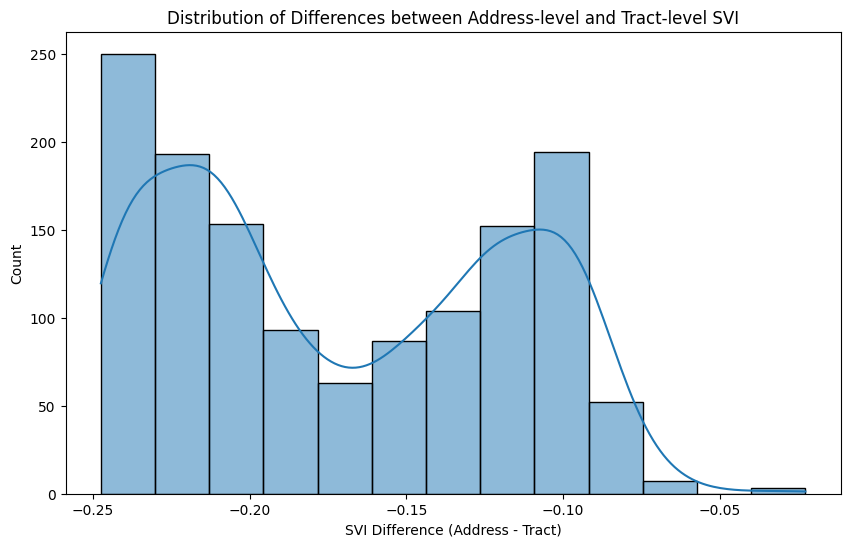

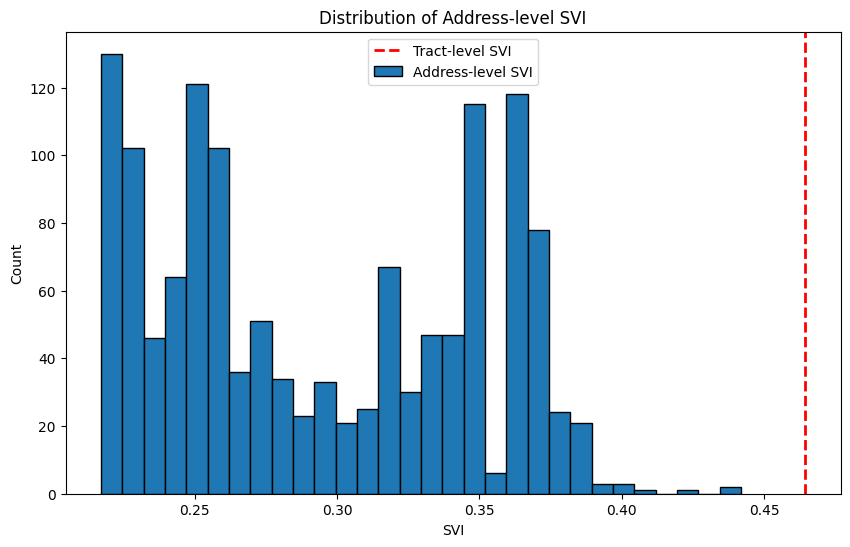

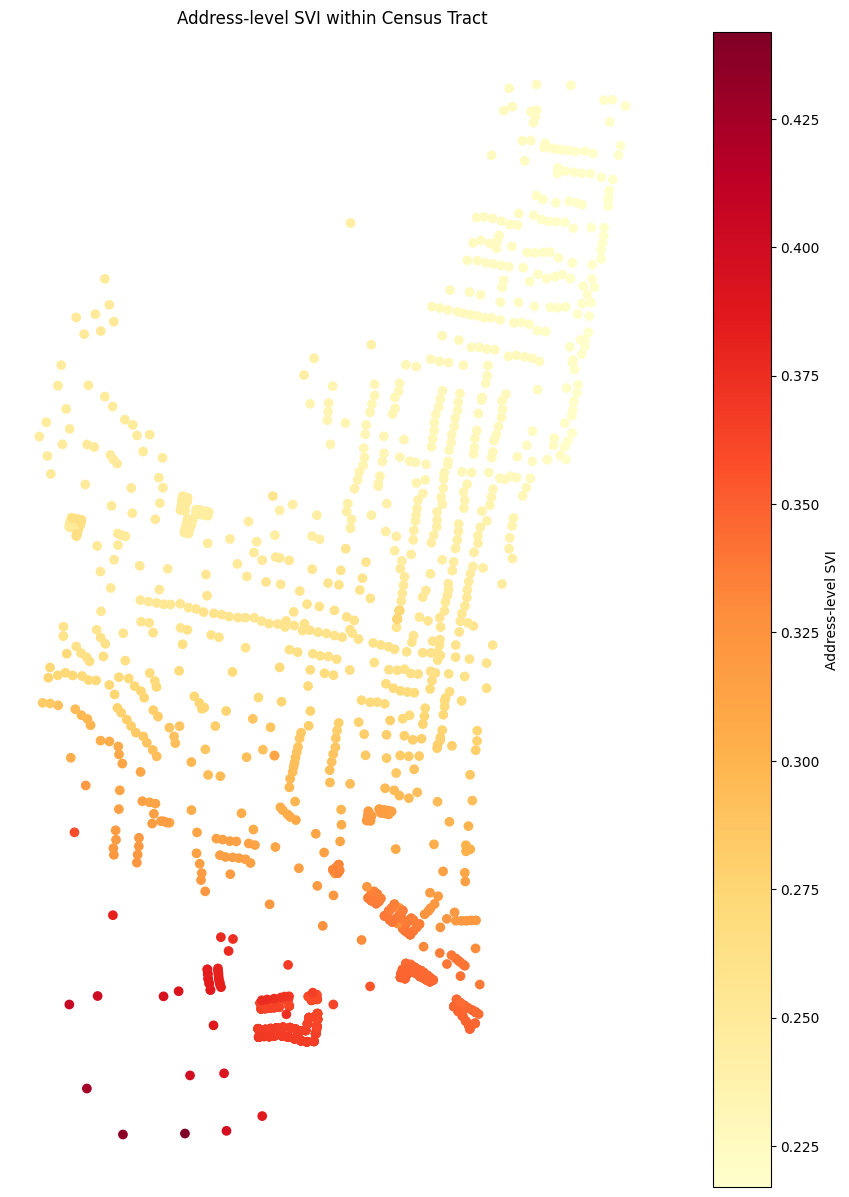

The mean SVI difference is: -0.1711212578499618


In [26]:
# Usage
summary_stats = validate_svi_results(result_df)

print(f"The mean SVI difference is: {summary_stats['mean']}")

### Visualization

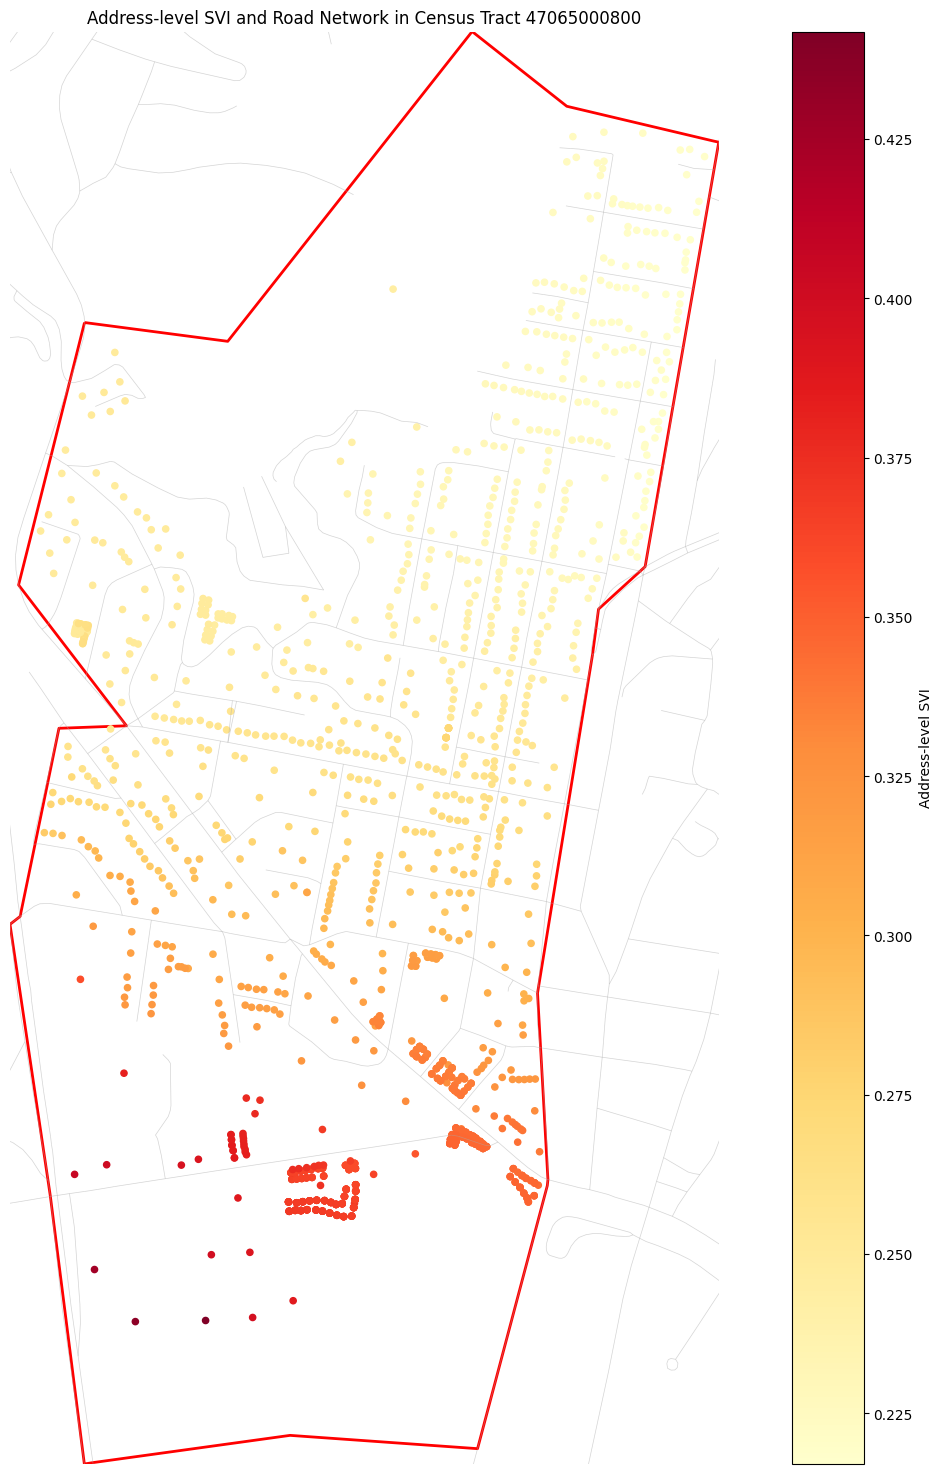

Number of addresses plotted: 1351
Extent of plot: (-442582.86429540045, 3928488.0303149796, -441389.4056409757, 3930900.136797158)
CRS of data: None


In [27]:
def visualize_address_svi_with_roads(
    result_df: gpd.GeoDataFrame,
    target_area: str,
    svi_df: gpd.GeoDataFrame,
    G: nx.Graph,
    output_file: str = None
):
    fig, ax = plt.subplots(figsize=(15, 15))

    # Get the target tract
    target_tract = svi_df[svi_df['FIPS'] == target_area]
    if target_tract.empty:
        raise ValueError(f"Target area {target_area} not found in svi_df")
    target_tract = target_tract.iloc[0]

    # Plot tract boundaries
    target_gdf = gpd.GeoDataFrame([target_tract], geometry='geometry')
    target_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

    # Filter addresses to only those within the tract
    result_df_filtered = result_df[result_df['FIPS'] == target_area]

    # Plot the address points, colored by SVI
    scatter = result_df_filtered.plot(column='address_level_svi',
                                      cmap='YlOrRd',
                                      legend=True,
                                      ax=ax,
                                      legend_kwds={'label': 'Address-level SVI'},
                                      markersize=20)

    # Plot graph edges
    edge_lines = []
    for u, v, data in G.edges(data=True):
        if 'geometry' in data:
            edge_lines.append(data['geometry'])

    edge_gdf = gpd.GeoDataFrame(geometry=edge_lines, crs=target_gdf.crs)
    edge_gdf.plot(ax=ax, color='darkgray', linewidth=0.5, alpha=0.5)

    # Set the plot extent
    bounds = target_tract.geometry.bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

    plt.title(f'Address-level SVI and Road Network in Census Tract {target_area}')
    plt.axis('off')
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

    # Print some debugging information
    print(f"Number of addresses plotted: {len(result_df_filtered)}")
    print(f"Extent of plot: {bounds}")
    print(f"CRS of data: {target_gdf.crs}")

# Call the visualization function
visualize_address_svi_with_roads(
    result_df=result_df,
    target_area=target_area,
    svi_df=svi_df,
    G=G
)

# FORMULAS

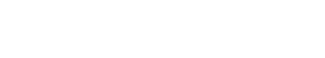

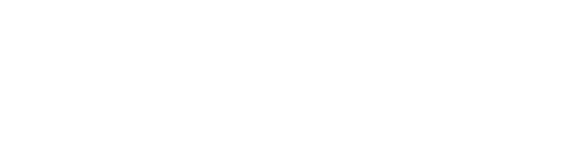

where...

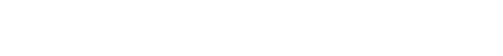

E_c(p,n): The combined inverse elasticity between point p and neighboring area n.

w: The network weight (between 0 and 1). It determines the balance between network and Euclidean distance in the calculation.

λ (lambda): The decay parameter. It controls how quickly the influence decreases with distance.

d_n(p,n): The network distance between point p and the nearest point in neighboring area n.

d_e(p,n): The Euclidean distance between point p and the nearest point in neighboring area n.

e: The mathematical constant e (approximately 2.71828), base of natural logarithms.

s_t: The index value (e.g., SVI) of the target area.

s_n: The index value (e.g., SVI) of the neighboring area n.

β (beta): The exponent for the index difference. It controls how sensitive the calculation is to differences in the index values.

|s_t - s_n|: The absolute difference between the index values of the target and neighboring areas.


In [28]:
# The above is identical to the below, but the above is simpler

\text{For each target area } t:
\begin{aligned}
  &\text{For each point } p \text{ in } t:\\
  &\quad\text{For each neighboring area } n:\\
  &\qquad E_e(p,n) = e^{-\lambda d_e(p,n)} / |s_t - s_n|^\beta &\quad&\text{(Euclidean inverse elasticity)}\\
  &\qquad E_n(p,n) = e^{-\lambda d_n(p,n)} / |s_t - s_n|^\beta &\quad&\text{(Network inverse elasticity)}\\
  &\qquad E_c(p,n) = w \cdot E_n(p,n) + (1 - w) \cdot E_e(p,n) &\quad&\text{(Combined inverse elasticity)}\\
  &\\
  &\quad W(p,n) = \frac{E_c(p,n)}{\sum_n E_c(p,n)} &\quad&\text{(Normalized weight)}\\
  &\quad s_p = s_t + \sum_n \left(W(p,n) \cdot (s_n - s_t)\right) &\quad&\text{(Weighted index for point }p\text{)}\\
  &\\
  &S_t = \frac{\sum_p s_p}{P} &\quad&\text{(Final weighted index for target area)}
\end{aligned}

\text{Where:}

\begin{aligned}

&d_e(p,n) \text{ is the Euclidean distance}\

&d_n(p,n) \text{ is the network distance}\

&\lambda \text{ is the decay parameter}\

&\beta \text{ is the exponent for index difference sensitivity}\

&w \text{ is the network weight}\

&s_t \text{ is the index value of the target area}\

&s_n \text{ is the index value of the neighboring area}\

&P \text{ is the total number of points in the target area}

\end{aligned}

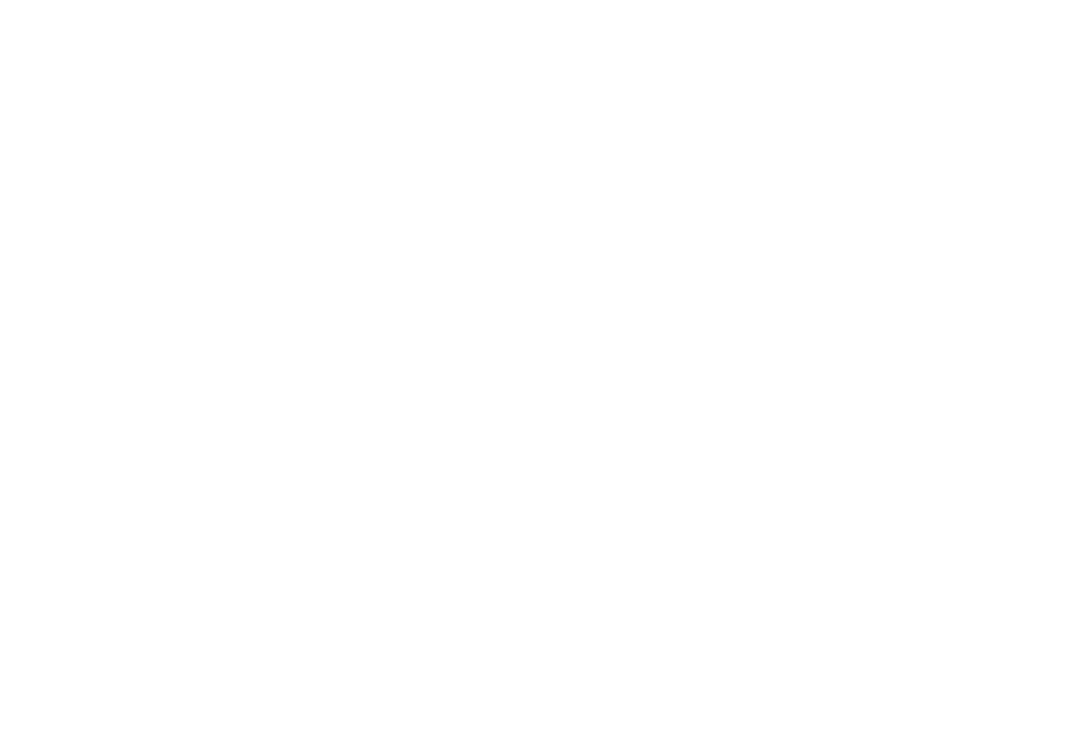

In [29]:
# And, the simplest representation (this is the first formula, but reduced):

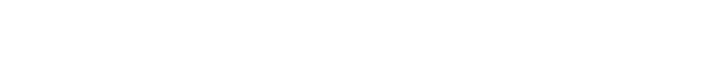

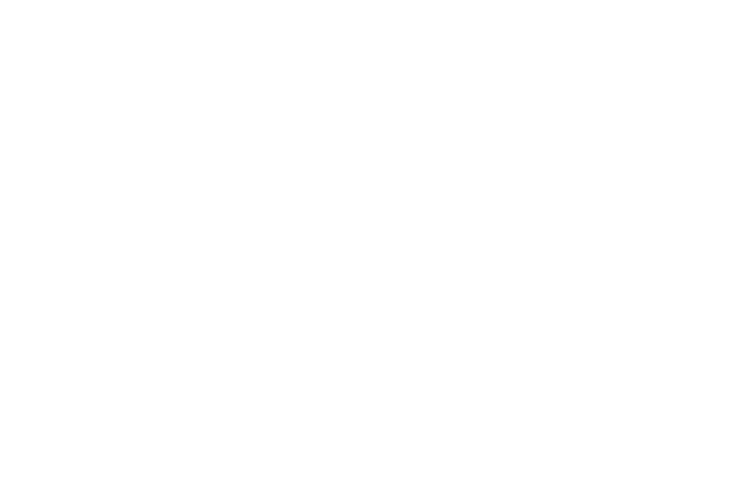

E_c(p,n) = e^{\frac{-\lambda \cdot (w \cdot d_n(p,n) + (1-w) \cdot d_e(p,n))}{|s_t - s_n|^\beta}}

Explanation of terms:

$E_c(p,n)$: The combined inverse elasticity between point $p$ and neighboring area $n$.
$e$: The mathematical constant e (Euler's number, approximately 2.71828), base of natural logarithms.
$\lambda$ (lambda): The decay parameter. It controls how quickly the influence decreases with distance.
$w$: The network weight (between 0 and 1). It determines the balance between network and Euclidean distance in the calculation.
$d_n(p,n)$: The network distance between point $p$ and the nearest point in neighboring area $n$.
$d_e(p,n)$: The Euclidean distance between point $p$ and the nearest point in neighboring area $n$.
$s_t$: The index value (e.g., SVI) of the target area containing point $p$.
$s_n$: The index value (e.g., SVI) of the neighboring area $n$.
$\beta$ (beta): The exponent for the index difference. It controls how sensitive the calculation is to differences in the index values.
$|s_t - s_n|$: The absolute difference between the index values of the target and neighboring areas.

This formula calculates the combined inverse elasticity by:

Computing a weighted average of network and Euclidean distances: $w \cdot d_n(p,n) + (1-w) \cdot d_e(p,n)$
Scaling this distance by the decay parameter $\lambda$
Dividing by the absolute difference in index values raised to the power $\beta$
Taking the negative of this value as the exponent of $e$

The result is a value between 0 and 1, where higher values indicate stronger influence (less "stretch" in your elastic band analogy) between the point and the neighboring area.